In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import h5py

import os
os.environ['CUDA_VISIBLE_DEVICES']="2"

#physical_devices = tf.config.list_physical_devices('GPU')
#print(physical_devices)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read data and MC

In [2]:
data = pd.read_pickle("datafiles/data.pkl")
mc = pd.read_pickle("datafiles/Rapgap_nominal.pkl")

In [3]:

theta_unknown_S = data[['event_y_es','event_Q2_es','event_y_s','event_Q2_s','event_y_e', 'event_Q2_e',
                        'e_px','e_py','e_pz','HFS_px','HFS_py','HFS_pz','HFS_E','HFS_eta']].to_numpy()
theta0_S = mc[['event_y_es','event_Q2_es','event_y_s','event_Q2_s','event_y_e', 'event_Q2_e',
               'e_px','e_py','e_pz','HFS_px','HFS_py','HFS_pz','HFS_E','HFS_eta']].to_numpy()
theta0_G = mc[['gen_event_y_es','gen_event_Q2_es','gen_event_y_s','gen_event_Q2_s','gen_event_y_e', 'gen_event_Q2_e',
               'gene_px','gene_py','gene_pz','genHFS_px','genHFS_py','genHFS_pz','genHFS_E','genHFS_eta']].to_numpy()

weights_MC_sim = mc['wgt']
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])
del mc
_ = gc.collect()

NNweights_step2 = np.ones(len(theta0_G))


## Load Trained Model

In [4]:
mymodel = tf.keras.models.load_model("models/Rapgap_nominal_step1_iteration0", compile=False)
iteration = 0 

In [5]:
scaler_data = StandardScaler()
scaler_data.fit(theta_unknown_S)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
mypred = mymodel.predict(scaler_data.transform(np.nan_to_num(theta0_S,posinf=0,neginf=0)),batch_size=10000)
mypred = mypred/(1.-mypred)
mypred = mypred[:,0]
mypred = np.squeeze(np.nan_to_num(mypred,posinf=1))

In [7]:
#y eSigma
bins = {}

bins[0] = np.logspace(np.log10(0.01),np.log10(1),9)
bins[1] = np.logspace(np.log10(0.01),np.log10(1),40)

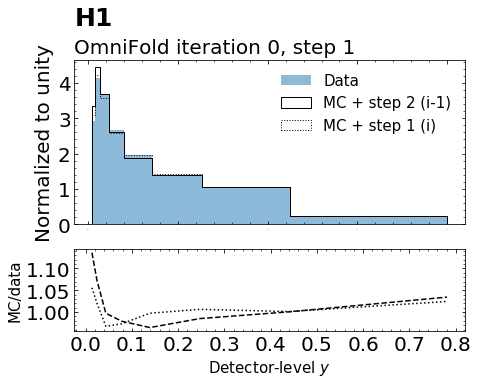

In [8]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)

n_data,b,_=plt.hist(theta_unknown_S[:,0],bins=bins[0],density=True,alpha=0.5,label="Data")
n_MC,_,_=plt.hist(theta0_S[pass_reco==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_reco==1]*NNweights_step2[pass_reco==1],density=True,histtype="step",color="black",label="MC + step 2 (i-1)")
#n_MC2,_,_=plt.hist(theta0_S[pass_reco==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_reco==1],density=True,histtype="step",color="black",label="No weight")


n_Omni_step1_y,_,_=plt.hist(theta0_S[pass_reco==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_reco==1]*NNweights_step2[pass_reco==1]*mypred[pass_reco==1],density=True,histtype="step",color="black",ls=":",label="MC + step 1 (i)")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("OmniFold iteration "+str(iteration)+", step 1",loc="left",fontsize=20)
plt.text(0.05, 1.25,'H1', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
    #plt.ylim([0,0.8])

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xlabel("Detector-level $y$",fontsize=15)
plt.ylabel("MC/data",fontsize=15)

plt.plot(0.5*(b[0:-1]+b[1:]),n_MC/n_data,ls="--",color="black")
#plt.plot(0.5*(b[0:-1]+b[1:]),n_MC2/n_data,ls="--",color="black")

plt.plot(0.5*(b[0:-1]+b[1:]),n_Omni_step1_y/n_data,ls=":",color="black")

In [ ]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)

n_data,b,_=plt.hist(theta_unknown_S[:,4],bins=bins[0],density=True,alpha=0.5,label="Data")
n_MC,_,_=plt.hist(theta0_S[pass_reco==1][:,4],bins=bins[0],weights=weights_MC_sim[pass_reco==1]*NNweights_step2[pass_reco==1],density=True,histtype="step",color="black",label="MC + step 2 (i-1)")
#n_MC2,_,_=plt.hist(theta0_S[pass_reco==1][:,4],bins=bins[0],weights=weights_MC_sim[pass_reco==1],density=True,histtype="step",color="black",label="No weight")


n_Omni_step1_y,_,_=plt.hist(theta0_S[pass_reco==1][:,4],bins=bins[0],weights=weights_MC_sim[pass_reco==1]*NNweights_step2[pass_reco==1]*mypred[pass_reco==1],density=True,histtype="step",color="black",ls=":",label="MC + step 1 (i)")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("OmniFold iteration "+str(iteration)+", step 1",loc="left",fontsize=20)
plt.text(0.05, 1.25,'H1', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
    #plt.ylim([0,0.8])

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xlabel("Detector-level $y$",fontsize=15)
plt.ylabel("MC/data",fontsize=15)

plt.plot(0.5*(b[0:-1]+b[1:]),n_MC/n_data,ls="--",color="black")
#plt.plot(0.5*(b[0:-1]+b[1:]),n_MC2/n_data,ls="--",color="black")

plt.plot(0.5*(b[0:-1]+b[1:]),n_Omni_step1_y/n_data,ls=":",color="black")

In [9]:
NNweights = mymodel.predict(scaler_data.transform(np.nan_to_num(theta0_S[pass_truth==1],posinf=0,neginf=0)),batch_size=10000)
NNweights = NNweights/(1.-NNweights)
NNweights = NNweights[:,0]
NNweights = np.squeeze(np.nan_to_num(NNweights,posinf=1))
NNweights[pass_reco[pass_truth==1]==0] = 1.

## Step 2

In [10]:
mymodel = tf.keras.models.load_model("models/Rapgap_nominal_step2_iteration0", compile=False)
iteration = 0 

In [11]:
NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
NNweights_step2_hold = NNweights_step2_hold[:,0]
NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
NNweights_step2_hold[pass_truth==0] = 1.
NNweights_step2 = NNweights_step2_hold*NNweights_step2

<ipython-input-11-f9819af8e11b>:2: RuntimeWarning: divide by zero encountered in true_divide
  NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)


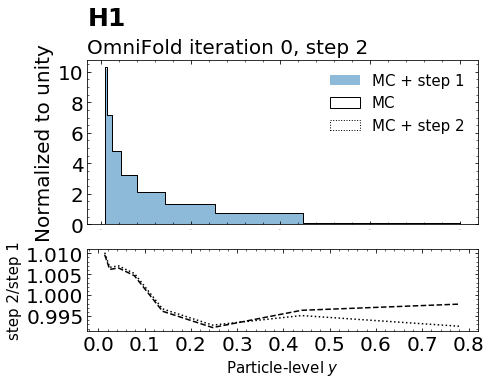

In [12]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)

n_data,b,_=plt.hist(theta0_G[pass_fiducial==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_fiducial==1]*NNweights[pass_fiducial==1]*NNweights_step2[pass_fiducial==1]/NNweights_step2_hold[pass_fiducial==1],density=True,alpha=0.5,label="MC + step 1")
n_MC,_,_=plt.hist(theta0_G[pass_fiducial==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_fiducial==1],density=True,histtype="step",color="black",label="MC")
n_Omni_step2_y,_,_=plt.hist(theta0_G[pass_fiducial==1][:,0],bins=bins[0],weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],density=True,histtype="step",color="black",ls=":",label="MC + step 2")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("OmniFold iteration "+str(iteration)+", step 2",loc="left",fontsize=20)
plt.text(0.05, 1.25,'H1', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
    #plt.ylim([0,0.8])

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xlabel("Particle-level $y$",fontsize=15)
plt.ylabel("step 2/step 1",fontsize=15)

plt.plot(0.5*(b[0:-1]+b[1:]),n_MC/n_data,ls="--",color="black")
plt.plot(0.5*(b[0:-1]+b[1:]),n_Omni_step2_y/n_data,ls=":",color="black")


In [ ]:
#NNweights_step2 = np.ones(len(theta0_G))
#mymodel = tf.keras.models.load_model("models/Rapgap_nominal", compile=False)
#NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
#NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
#NNweights_step2_hold = NNweights_step2_hold[:,0]
#NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
#NNweights_step2_hold[pass_truth==0] = 1.
#NNweights_step2 = NNweights_step2_hold*NNweights_step2